In [16]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os.path
from matplotlib.ticker import MaxNLocator
import warnings



In [2]:
cwd = pathlib.Path().resolve()
src = cwd.parent

# Replace with your own directory path
root = src.parent
data = src.parent.parent.parent
data_path = os.path.join(data, 'data_tana')
sys.path.append(str(src))
sys.path.append(str(root))
sys.path.append(str(data_path))

# Recent data Garissa processing

In [15]:
#Replace with your own data
path = os.path.join(data_path, 'Garissa_Tana_recent.csv')
df_garissa_recent = pd.read_csv(path, sep = ';')
df_garissa_recent = df_garissa_recent.dropna(how = 'all')


# Some required data cleanup. Some empty columns are removed, the hourly data is removed and the 
# columns are renamed for later purpose
columns_to_drop = [2, 3]  
df_garissa_recent = df_garissa_recent.drop(df_garissa_recent.columns[columns_to_drop], axis=1)
df_garissa_recent = df_garissa_recent[21:]
df_garissa_recent = df_garissa_recent.rename(columns={"Time": "date_level", "4G01-TANA-WATER LEVEL-RAW": "waterlevel[m]",
                                                     "Time.1":"date_discharge", "4G01-TANA-DISCHARGE": "discharge[m3/s]"})

#Convert the (mixed) time dataset into a standard datetime format 
df_garissa_recent['date_level'] = pd.to_datetime(df_garissa_recent['date_level'], format='mixed')
df_garissa_recent['date_discharge'] = pd.to_datetime(df_garissa_recent['date_discharge'], format='mixed')


In [4]:
# To compare the mismatched timesteps the dataset is split-up into two different datasets:
# The discharge contains the date and discharge and time, the other water level and time
columns_discharge = [2,3]
columns_level = [0,1]
df_garissa_matched = df_garissa_recent.drop(df_garissa_recent.columns[columns_discharge], axis =1)
df_garissa_discharge = df_garissa_recent.drop(df_garissa_recent.columns[columns_level], axis =1)

In [6]:
# Due to some strange formatting of the data some entries are double or missing. This function removes any
# mismatching data entries ensuring that the top entry of each dataset is the same timestamp in the same format

def remove_row(df_garissa_matched, df_garissa_discharge):
    if df_garissa_matched.empty or df_garissa_discharge.empty: # Stop the function if the dataset is empty
        return df_garissa_matched, df_garissa_discharge
    if df_garissa_matched.iloc[0, 0] == df_garissa_discharge.iloc[0, 0]: # Stop the function if entries match
        return df_garissa_matched, df_garissa_discharge
    elif df_garissa_discharge.iloc[0, 0].timestamp() - df_garissa_matched.iloc[0, 0].timestamp() > 0: 
        df_garissa_matched = df_garissa_matched[1:]  #Remove the first water level entry if needed
        return remove_row(df_garissa_matched, df_garissa_discharge) # Recursively restart function to check again
    else:
        df_garissa_discharge = df_garissa_discharge[1:] # Remove discharge entry if needed
        return remove_row(df_garissa_matched, df_garissa_discharge) # Recursively restart function to check again
        

In [17]:
# Nasty bit of code that Jenga tower like removes the first entry of the dataset (after matching times are ensured)
# and adds it to a new dataset containing the matched data in a new dataframe. This dataframe will contain three
# columns: water level, discharge and a timestamp. 

run_recent_tana = False #Change to true if needed.

if run_recent_tana == True: 
    unready = True
    matched_data = pd.DataFrame() # empty dataframe for the water level and date
    discharge = [] # empty array for the discharge
    safety_stop = 0   
    safety_stop_max = len(df_garissa_discharge) #prevent infinite loop in case data format is incorrect 

    # Looping through entire dataset. 

    while unready:
        safety_stop += 1
        df_garissa_matched, df_garissa_discharge = remove_row(df_garissa_matched, df_garissa_discharge) #run remove 
        if safety_stop > safety_stop_max:
            unready = False
            warnings.warn("Dataset not in expected format, conversion failed")
        if df_garissa_matched.empty or df_garissa_discharge.empty: # Check needs to happen twice to break out of 
            #both the function and the loop.
            unready = False
            break

        # Data manipulation into the correct format

        discharge.append(df_garissa_discharge.iloc[0,1])
        new_level = df_garissa_matched.iloc[0,:].to_frame().T
        matched_data = pd.concat([matched_data, new_level], ignore_index=True)
        df_garissa_matched = df_garissa_matched[1:]

    #Adding the discharge array and completing the Dataset
    discharge_column = pd.Series(discharge, name='discharge[m3/s]')
    matched_data = pd.concat([matched_data, discharge_column], axis=1)

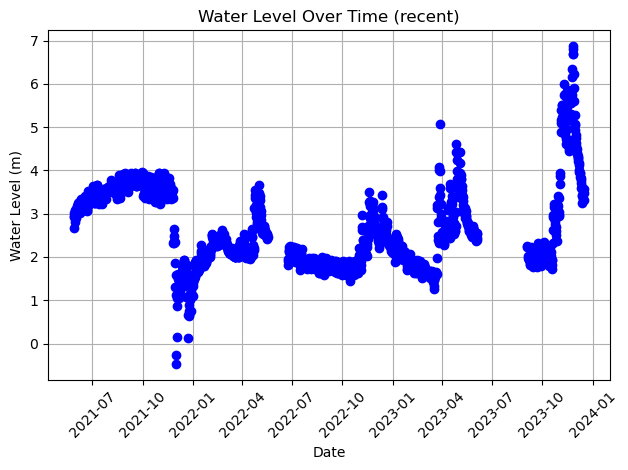

In [29]:
n = 12  # Plot every nth data point
plt.plot(matched_data['date_level'][::n], matched_data['waterlevel[m]'][::n], marker='o', linestyle='', color='b')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.title('Water Level Over Time (recent)')
plt.xticks(rotation=45)
#plt.ylim(0,8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
path = os.path.join(data_path, 'fixed_recent_data_Garissa.csv')
matched_data.to_csv(path, index = False)

# Historical data Garissa processing 

In [36]:
#Replace with your own data
path = os.path.join(data_path, 'Garissa_Tana_historical.csv')
df_garissa_his = pd.read_csv(path, sep = ';')
df_garissa_his = df_garissa_his.dropna()

columns_to_drop = [0,3]  
df_garissa_his = df_garissa_his.drop(df_garissa_his.columns[columns_to_drop], axis=1)

df_garissa_his = df_garissa_his.rename(columns={"Time": "date", "4G01 TANA GARISSA - WaterLevel [m]": "waterlevel[m]",
                                                    "4G01 TANA GARISSA DISCHARGE [m^3/s]": "discharge[m3/s]"})

In [44]:
df_garissa_his.head()

,date,waterlevel[m],discharge[m3/s]
0,18/04/1941,5.27,1683.0030
2,19/04/1941,5.18,1609.1140
6,21/04/1941,4.88,1377.3840
8,22/04/1941,4.58,1167.4480
10,23/04/1941,2.76,351.5418


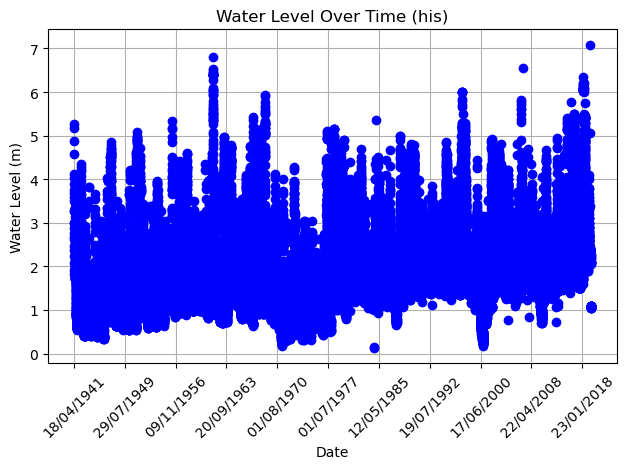

In [43]:
n = 1  # Plot every nth data point
plt.plot(df_garissa_his['date'][::n], df_garissa_his['waterlevel[m]'][::n], marker='o', linestyle='', color='b')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.title('Water Level Over Time (his)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=12))
#plt.ylim(0,8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
path = os.path.join(data_path, 'fixed_historical_data_Garissa.csv')
df_garissa_his.to_csv(path, index = False)